In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import csv
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score

In [2]:
nlp = spacy.load('en')

In [3]:
def load_csv(path):
    data = []

    with open(path, 'r',  encoding="iso-8859-1") as fin:
        reader = csv.reader(fin, quotechar='"')
        columns = next(reader)
        for line in reader:
            data.append(line)

    df = pd.DataFrame(data, columns=columns)

    return df

# Load the Data

In [4]:
train_df = load_csv('train.csv')

In [5]:
train_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,Hillary Clinton,FAVOR,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos


In [6]:
test_df = load_csv('test.csv')
test_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; and he who humbles himself shall be exalted.Matt 23:12. #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
1,"RT @prayerbullets: I remove Nehushtan -previous moves of God that have become idols, from the high places -2 Kings 18:4 #SemST",Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other
2,@Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
3,#God is utterly powerless without Human intervention... #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@David_Cameron Miracles of #Multiculturalism Miracles of shady 786 #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST,Atheism,AGAINST,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg


# Plot the distributions of the data

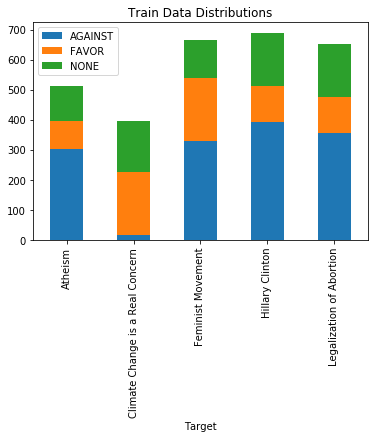

In [7]:
train_df.groupby(['Target', 'Stance']).size().unstack().plot(kind='bar', stacked=True)
plt.legend(loc='best')
plt.title('Train Data Distributions')
plt.show()

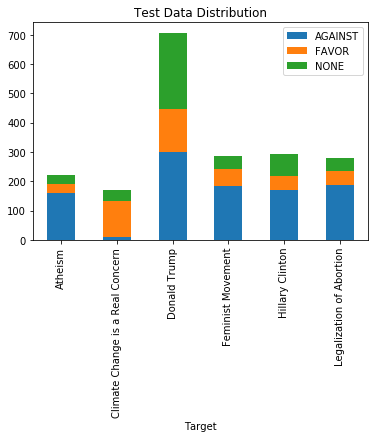

In [8]:
test_df.groupby(['Target', 'Stance']).size().unstack().plot(kind='bar', stacked=True)
plt.legend(loc='best')
plt.title('Test Data Distribution')
plt.show()

In [9]:
targets = list(train_df['Target'].unique())

In [10]:
stances = list(train_df['Stance'].unique())

# Define scoring metrics

In [11]:
def f1_favor(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro', labels=['FAVOR'])

def f1_against(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro', labels=['AGAINST'])

def f1_none(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro', labels=['NONE'])

def f1_avg(y_true, y_pred):
    return np.mean([f1_favor(y_true, y_pred), f1_against(y_true, y_pred)])

def f1_avg_scorer(clf, X, y):
    y_pred = clf.predict(X)
    return f1_avg(y, y_pred)

# Normalise the Tweet Text

In [12]:
def normalise_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_digit and not token.is_punct])

In [13]:
train_df['Clean Tweet'] = train_df['Tweet'].apply(normalise_text)
test_df['Clean Tweet'] = test_df['Tweet'].apply(normalise_text)

In [14]:
train_df.head()[['Tweet', 'Clean Tweet']]

,Tweet,Clean Tweet
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",@tedcruz handovertheserver wipe clean + 30k delete email explain dereliction duty lie benghazi tcot
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,hillary good choice truly want continue progressive nation ohio
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",@theview think country ready female pre not hillary
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,give unhealthy hard earn money away big gov't untrustworthy irs whyimnotvotingforhillary
4,@PortiaABoulger Thank you for adding me to your list,@portiaaboulger thank add list


In [15]:
flatten = lambda l: [item for sublist in l for item in sublist]

# Cross Validate

In [16]:
for target in targets:
    pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('svd', TruncatedSVD(n_components=500)),
        ('norm', Normalizer(copy=False)),
        ('svm', SGDClassifier(max_iter=5000, tol=1e-3, random_state=42, alpha=1e-3, penalty='elasticnet'))
    ])
    
    train = train_df.loc[train_df['Target'] == target]
    score = cross_validate(pipe, train['Clean Tweet'], train['Stance'], cv=5, scoring=f1_avg_scorer, return_train_score=True)
    print(f'{target}')
    print(f"Train Score: {np.mean(score['train_score'])} +/- {np.std(score['train_score'])}")
    print(f"Test Score: {np.mean(score['test_score'])} +/- {np.std(score['test_score'])}")


Hillary Clinton
Train Score: 0.9639575031467299 +/- 0.005758700608192717
Test Score: 0.5271756588860275 +/- 0.0717819722531802
Legalization of Abortion
Train Score: 0.9739479406390972 +/- 0.007773075380737331
Test Score: 0.616861586707788 +/- 0.1077706056592856
Atheism
Train Score: 0.9910754557305573 +/- 0.002836002884531877
Test Score: 0.6388470218009912 +/- 0.060078997668752104


/Users/uwaisiqbal/miniconda3/envs/eigen/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Climate Change is a Real Concern
Train Score: 0.9994134897360704 +/- 0.0007183254377663272
Test Score: 0.46432620009462455 +/- 0.16823003910249656
Feminist Movement
Train Score: 0.9641381198594994 +/- 0.0057530778191738335
Test Score: 0.5861197154655426 +/- 0.04166249738633588


# Evaluate on Test Data

In [17]:
scores_df = pd.DataFrame()
models = {}
labels_df = pd.DataFrame()
for target in targets:

    pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('svd', TruncatedSVD(n_components=500)),
        ('norm', Normalizer(copy=False)),
        ('svm', SGDClassifier(max_iter=5000, tol=1e-3, random_state=42, alpha=1e-3, penalty='elasticnet'))
    ])
    
    train = train_df.loc[train_df['Target'] == target]
    test = test_df.loc[test_df['Target'] == target]
    
    _ = pipe.fit(train['Clean Tweet'], train['Stance'])
    y_pred = pipe.predict(test['Clean Tweet'])
    y_true = list(test['Stance'])
    models[target] = pipe

    labels_df = labels_df.append({'y_true': y_true, 'y_pred': y_pred, 'target': target}, ignore_index=True)
    scores_df = scores_df.append(
        {'F1 Avg': f1_avg(y_true, y_pred) * 100, 
         'F1 Favor': f1_favor(y_true, y_pred) * 100, 
         'F1 Against': f1_against(y_true, y_pred) * 100,
         'Target': target}, 
        ignore_index=True)

    
overall_f1_avg = f1_avg(flatten(list(labels_df['y_true'])), flatten(list(labels_df['y_pred']))) * 100
overall_f1_against = f1_against(flatten(list(labels_df['y_true'])), flatten(list(labels_df['y_pred']))) * 100
overall_f1_favor = f1_favor(flatten(list(labels_df['y_true'])), flatten(list(labels_df['y_pred']))) * 100

print('Overall Scores')
print(f'F1 Avg: {overall_f1_avg}')
print(f'F1 Favor: {overall_f1_favor}')
print(f'F1 Against: {overall_f1_against}')

scores_df

Overall Scores
F1 Avg: 63.678179059180586
F1 Favor: 53.76
F1 Against: 73.59635811836117


,F1 Against,F1 Avg,F1 Favor,Target
0,76.923077,58.179848,39.436620,Hillary Clinton
1,73.590504,58.223824,42.857143,Legalization of Abortion
2,78.260870,57.774503,37.288136,Atheism
3,16.666667,46.449925,76.233184,Climate Change is a Real Concern
4,67.711599,55.105799,42.500000,Feminist Movement
